### Computing BX BY and BZ via Equivalent layer in one Grid of data - By Valeria CF Barbosa

### Using a single grid of observations

###  The direction of the geomagnetic Field  is the variables inc and dec 
###  The simulated  prism body  has magnetization direction of incs and decs
###  The equivalent layer has dipoles as equivalent sources with magnetization direction of inc_eq and dec_eq (*)

#### (*) The sensitivity matrix used in the equivalent layer is computed by the total field anomaly produced by a set of dipoles with unit magnetic moment and with magnetization direction of inc_eq and dec_eq. I used the sphere.tf from Fatiando





In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af
import auxiliary_functions_Larissa_Project as af_L

from datetime import datetime

import fatiando
from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.gravmag.eqlayer import EQLGravity
from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang, contaminate, dircos
from fatiando.constants import G, SI2MGAL

C:\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
C:\Anaconda2\lib\site-packages\fatiando\vis\myv.py:53: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


Executed auxiliary_functions_Larissa_Project.py


In [2]:
from numpy import linalg
from scipy.optimize import nnls
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.stats import norm



In [3]:
notebook_name = 'Equivalent_Layer_Magnetic_Components.ipynb'

In [4]:
with open('../data/model_single.pickle') as f:
        full_model_single = pickle.load(f)

In [5]:
full_model_single

{'depth_model': [[500.0, 1000.0]],
 'metadata': 'Generated by synthetic_model_Single_Prims.ipynb on 10 October 2018 15:22:11 UTC',
 'model': [<fatiando.mesher.geometry.Prism at 0x3d40e80>],
 'projection': [[2200.0, 2800.0, -1000.0, 1000.0]]}

### GEOMAGNETIC FILED INFORMATION: Inclination and Declination of the ONE GRID 


In [6]:
Geomagnetic_Information = dict() #empty dictionary

In [7]:
#Geomagnetic_Information['geomag_field'] = [(6., -40.5)] # Only one Geomagnetic field only one grid of data

#Geomagnetic_Information['geomag_field'] = [(30., -10.0)] # Only one Geomagnetic field only one grid of data

Geomagnetic_Information['geomag_field'] = [(20., 10.0)] # Only one Geomagnetic field only one grid of data

print 'Inclination and Declination of the Geomagnetic Field of only one Grid '
print Geomagnetic_Information['geomag_field'][0]


Inclination and Declination of the Geomagnetic Field of only one Grid 
(20.0, 10.0)


In [8]:
number_geomag_field = len(Geomagnetic_Information['geomag_field'])
print 'Number of Geomagnetic Fields', number_geomag_field

Number of Geomagnetic Fields 1


In [9]:
inc, dec = Geomagnetic_Information['geomag_field'][0]

### Magnetic vector of the source

In [10]:
ints, incs, decs = vec2ang(full_model_single['model'][0].props['magnetization'])
print 'Intensity, Inclination and Declination of the sources '
print ints, incs, decs

Intensity, Inclination and Declination of the sources 
10.0 30.0 -10.0


### Load the grid of points

In [11]:
with open('../data/regular_single_grid.pickle') as f:
        regular_single_grid = pickle.load(f)
        

In [12]:
print ' Regular Grid Information '
regular_single_grid

 Regular Grid Information 


{'DS': 16228.49724115547,
 'N': 3200,
 'area': [0, 5000, -5000, 5000],
 'metadata': 'Generated by computation_points_one_grid_.ipynb on 10 October 2018 15:21:05 UTC',
 'shape': (40, 80),
 'spacing': [128.2051282051282, 126.58227848101266]}

In [13]:
print 126*2.5

315.0


### Define the coordinates on the observation surface

In [14]:
#coordinates x and y of the data
xp, yp = regular(regular_single_grid['area'], regular_single_grid['shape'])
print len(xp)

#vertical coordinates of the data 
#zp = af.observation_surface(xp,yp)

# vertical coordinates of the data
zp = np.zeros_like(xp)
height_obs = -50.

print len(zp)

assert (xp.size == regular_single_grid['N']) and (yp.size == regular_single_grid['N']) and (zp.size == regular_single_grid['N']),  \
                'xp and yp and zp must have the same size defined by shape of the single grid'


3200
3200


### Noise corrupted total-field anomaly


In [15]:
ruido_percent = 0.01
#ruido_percent = 0.0

In [16]:

tf, std_noise = contaminate(prism.tf(xp,yp,zp,full_model_single['model'],inc, dec), ruido_percent, percent=True, seed=47, return_stddev=True)
print 'standart deviation of the noise:', std_noise

standart deviation of the noise: 6.52437814096


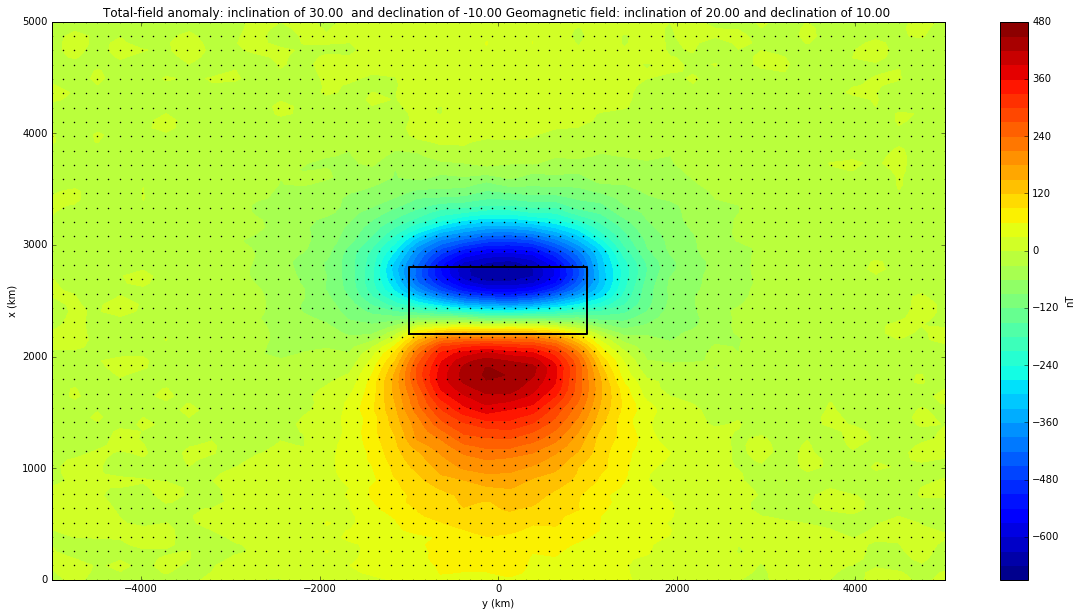

In [17]:
file_name = '..\\figs\\Observed_Total_Field'

plt.figure(figsize=(20, 10))
unit = 'nT'
mpl.contourf(yp, xp, tf, regular_single_grid['shape'], 40, interp=True)

plt.plot(yp, xp, 'k.', markersize=2)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('Total-field anomaly: inclination of %4.2f  and declination of %4.2f Geomagnetic field: inclination of %4.2f and declination of %4.2f ' \
%(incs, decs, inc, dec)) 


plt.savefig(file_name+'.eps', dpi=600)

In [18]:
Npts = len(tf)
print 'number of data: Npts', Npts

assert (xp.size == Npts) and (yp.size == Npts) and (zp.size == Npts),  \
                'xp, yp1 and zp must have the same size defined by Npts'


number of data: Npts 3200


## Planar equivalent layer

#### Parameters defining the equivalent Layer

In [19]:
print regular_single_grid['spacing'][0]* 2.5, regular_single_grid['spacing'][1]* 2.5

320.512820513 316.455696203


In [20]:
#horizontal plane containing the equivalent sources located at h 
z0 = np.zeros_like(zp)
#h = 400.
h = 600.
z0 += h
print h

600.0


## Estimated magnetic moment distribution

In [21]:
print regular_single_grid['area']

[0, 5000, -5000, 5000]


In [22]:
# creating the layer of the equivalent layer
layer = PointGrid(regular_single_grid['area'], z0, regular_single_grid['shape'])


In [23]:
M_source = len(layer)
print 'number of the equivalent sources at the equivalent layer: M_source', M_source

assert (M_source == Npts),'We are imposing that M_source must have the same size defined by Npts'


number of the equivalent sources at the equivalent layer: M_source 3200


### Sensitivity Matrix (dipoles) via Fatiando


In [24]:
# Inclination and declintion of the equivalent sources are Equal to Inclination and declintion of the true source dec_eq = decs

#mag_eq = dircos(incs, decs)
#print mag_eq

In [25]:
# Inclination and declintion of the equivalent sources are DIFFERENT to Inclination and declintion of the true source dec_eq = decs

inc_eq = 60.
dec_eq = 20.
mag_eq = dircos(inc_eq, dec_eq)
print mag_eq

[0.46984631039295432, 0.17101007166283438, 0.8660254037844386]


### Print the inclination and declination of the equivalent sources

In [26]:
# Verifying  the Inclination of the equivalent sources

if inc_eq == incs:
        print 'Inclination  of the equivalent sources %4.2f is EQUAL to the Inclination True source %4.2f:' %(inc_eq, incs) 
elif inc_eq != incs:
        print 'Inclination  of the equivalent sources %4.2f is DIFFERENT to the Inclination True source %4.2f:' %(inc_eq, incs) 

# Verifying  the Declination of the equivalent sources

if dec_eq == decs:
        print 'Declination of the equivalent sources %4.2f is EQUAL to the declination True source %4.2f:' %(dec_eq, decs) 
elif dec_eq != decs:
        print 'Declination of the equivalent sources %4.2f is DIFFERENT to the declination True source %4.2f:' %(dec_eq, decs) 

Inclination  of the equivalent sources 60.00 is DIFFERENT to the Inclination True source 30.00:
Declination of the equivalent sources 20.00 is DIFFERENT to the declination True source -10.00:


In [27]:
# Sensitivity Matrix from Fatiando
TF_Fatiando = np.empty((Npts,M_source),dtype =float)
for i, c in enumerate(layer):
    TF_Fatiando[:,i] = sphere.tf(xp, yp, zp, [c], inc, dec, pmag = mag_eq)
   

In [28]:
print inc, dec

20.0 10.0


In [29]:
now = datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')

start_time_ATA = datetime.now() 

ATA = np.empty((M_source,M_source),dtype =float)
ATA = np.dot(TF_Fatiando.T, TF_Fatiando)


end_time_ATA  = datetime.now()
print('Duration ATA: {}'.format(end_time_ATA  - start_time_ATA ))  

# Gradient

start_time_ATd = datetime.now() 

ATdo = np.dot(TF_Fatiando.T,tf)

end_time_ATd  = datetime.now()
print('Duration Atd: {}'.format(end_time_ATd  - start_time_ATd ))  

Duration ATA: 0:00:00.535000
Duration Atd: 0:00:00.003000


In [30]:
# Normalized Regularizing Parameter 

#mi_tkt = 1e-03
mi_tkt = 1e-02

reg_parameter = np.trace(ATA)/M_source  *  mi_tkt
print mi_tkt
print reg_parameter

0.01
5.13906980113e-14


In [31]:
Hessiana  = ATA + diags([reg_parameter], 0, (M_source,M_source), format='csr', dtype='float')
p = linalg.solve(Hessiana,ATdo)

In [32]:
tf_predicted    = np.dot(TF_Fatiando,p)
residual        = tf - tf_predicted

In [33]:
print  np.linalg.norm(residual)/Npts


0.102256419665


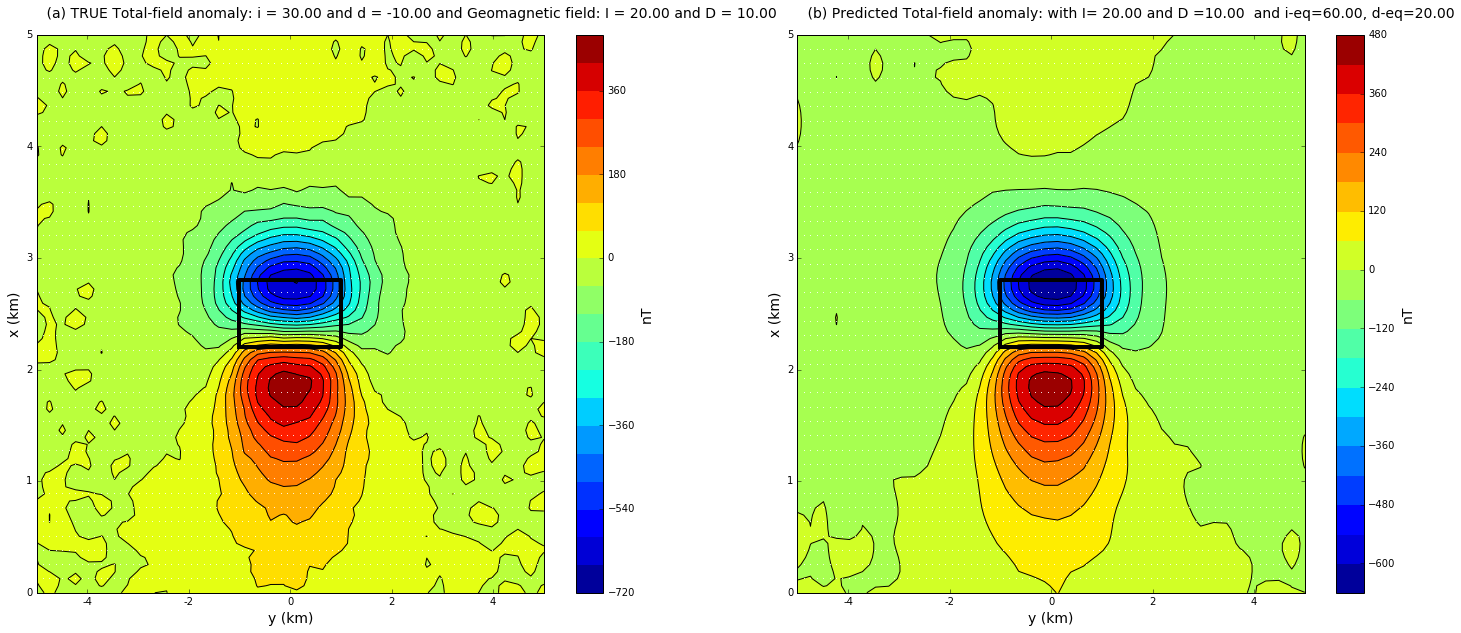

In [34]:
file_name = '..\\figs\\Predicted_Total_Field'

plt.figure(figsize=(25, 10))

af_L.Plot_Twomaps(xp, yp, tf, tf_predicted, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) TRUE Total-field anomaly: i = %4.2f and d = %4.2f and Geomagnetic field: I = %4.2f and D = %4.2f " %(incs, decs, inc, dec),  
                figure_title2 = " (b) Predicted Total-field anomaly: with I= %4.2f and D =%4.2f  and i-eq=%4.2f, d-eq=%4.2f" %(inc , dec, inc_eq, dec_eq),
                label_x = 'y (km)', label_y = 'x (km)', label_size= 14.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

plt.savefig(file_name+'.eps', dpi=600)


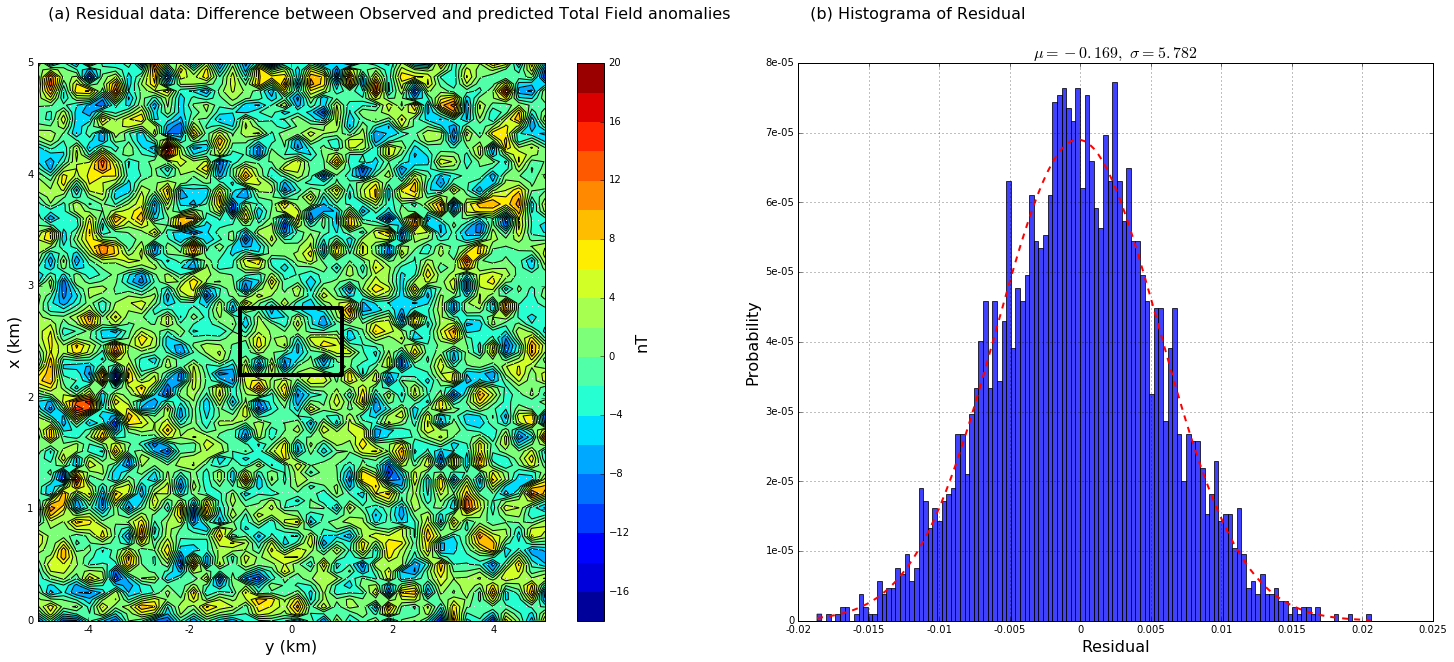

In [35]:
file_name = '..\\figs\\Residual_TF'

plt.figure(figsize=(25, 10))

af_L.Plot_Onemap_Histog(xp, yp, residual, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) Residual data: Difference between Observed and predicted Total Field anomalies  ", figure_title2 = " (b) Histograma of Residual   ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')


plt.savefig(file_name+'.eps', dpi=600)

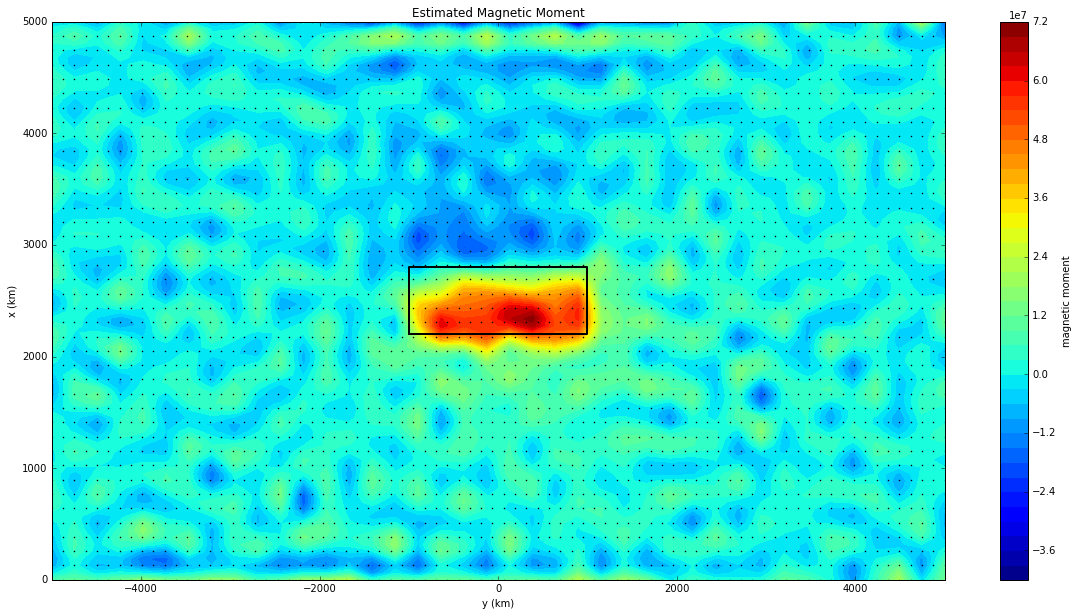

In [36]:
file_name = '..\\figs\\Estimated Magnetic Moment'

plt.figure(figsize=(20, 10))
unit = 'magnetic moment'
mpl.contourf(yp, xp, p , regular_single_grid['shape'], 40, interp=True)

plt.plot(yp, xp, 'k.', markersize=2)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('Estimated Magnetic Moment')


plt.savefig(file_name+'.eps', dpi=600)

In [37]:
with open('../data/model_single_pole.pickle') as f:
        full_model_single_pole = pickle.load(f)
print full_model_single_pole

{'projection_pole': [[2200.0, 2800.0, -1000.0, 1000.0]], 'model_pole': [<fatiando.mesher.geometry.Prism object at 0x0000000010B53A90>], 'metadata': 'Generated by synthetic_model_Single_Prims.ipynb on 10 October 2018 15:22:11 UTC'}


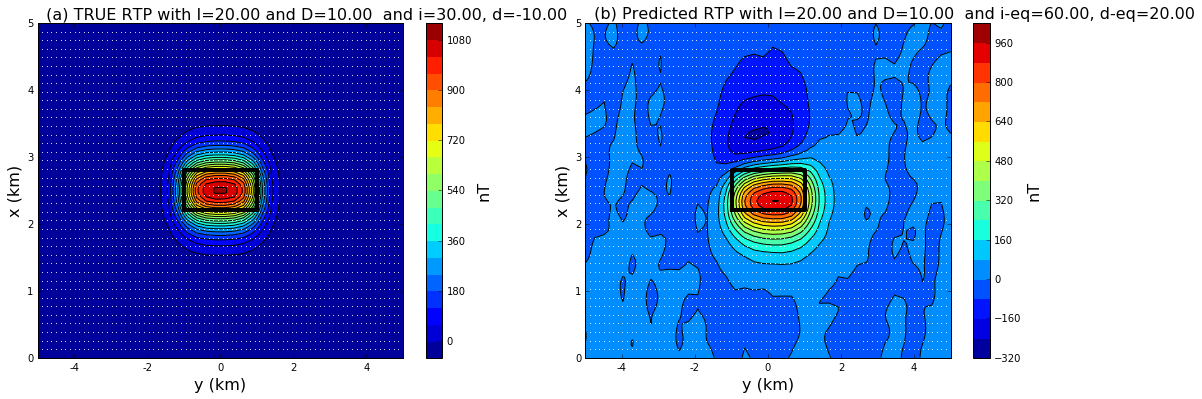

In [38]:
# equivalent layer
layer_pole = PointGrid(regular_single_grid['area'], z0, regular_single_grid['shape'])
layer_pole.addprop('magnetization', ang2vec(p, 90., 0.))

# predicted RTP anomaly
tf_pred_pole = sphere.tf(xp, yp, zp, layer_pole, 90., 0.)

#True RTP

tf_true_pole = prism.tf(xp,yp,zp,full_model_single_pole['model_pole'],90., 0.)

plt.figure(figsize=(18, 6))

af_L.Plot_Twomaps(xp, yp, tf_true_pole, tf_pred_pole, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) TRUE RTP with I=%4.2f and D=%4.2f  and i=%4.2f, d=%4.2f" %(inc , dec, incs, decs),
                figure_title2 = " (b) Predicted RTP with I=%4.2f and D=%4.2f  and i-eq=%4.2f, d-eq=%4.2f" %(inc , dec, inc_eq, dec_eq),
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')



In [39]:
### Computing the True Bx By and Bz

True_intensity, True_inclination, True_declination = vec2ang(full_model_single['model'][0].props['magnetization'])
print 'Intensity, Inclination and Declination of the sources '
print True_intensity, True_inclination, True_declination 

assert (ints == True_intensity) and (incs == True_inclination) and (decs == True_declination),  \
                'ints and incs and decs must have equal to True_intensity, True_inclination, True_declination '


Intensity, Inclination and Declination of the sources 
10.0 30.0 -10.0


In [40]:
BX_TRUE = prism.bx(xp, yp, zp, full_model_single['model'], pmag = None)
BY_TRUE = prism.by(xp, yp, zp, full_model_single['model'], pmag = None)
BZ_TRUE = prism.bz(xp, yp, zp, full_model_single['model'], pmag = None)

In [41]:
print full_model_single

{'depth_model': [[500.0, 1000.0]], 'metadata': 'Generated by synthetic_model_Single_Prims.ipynb on 10 October 2018 15:22:11 UTC', 'model': [<fatiando.mesher.geometry.Prism object at 0x0000000003D40E80>], 'projection': [[2200.0, 2800.0, -1000.0, 1000.0]]}


In [42]:
# Inclination and declintion of the equivalent sources
print mag_eq

[0.46984631039295432, 0.17101007166283438, 0.8660254037844386]


In [43]:
# Sensitivity Matrix from Fatiando
BX_Fatiando = np.empty((Npts,M_source),dtype =float)
BY_Fatiando = np.empty((Npts,M_source),dtype =float)
BZ_Fatiando = np.empty((Npts,M_source),dtype =float)
for i, c in enumerate(layer):
    BX_Fatiando[:,i] = sphere.bx(xp, yp, zp, [c], pmag = mag_eq)
    BY_Fatiando[:,i] = sphere.by(xp, yp, zp, [c], pmag = mag_eq)
    BZ_Fatiando[:,i] = sphere.bz(xp, yp, zp, [c], pmag = mag_eq)


In [44]:
BX_predicted    = np.dot(BX_Fatiando,p)
BY_predicted    = np.dot(BY_Fatiando,p)
BZ_predicted    = np.dot(BZ_Fatiando,p)


In [45]:
Residual_BX = BX_TRUE - BX_predicted
Residual_BY = BY_TRUE - BY_predicted
Residual_BZ = BZ_TRUE - BZ_predicted



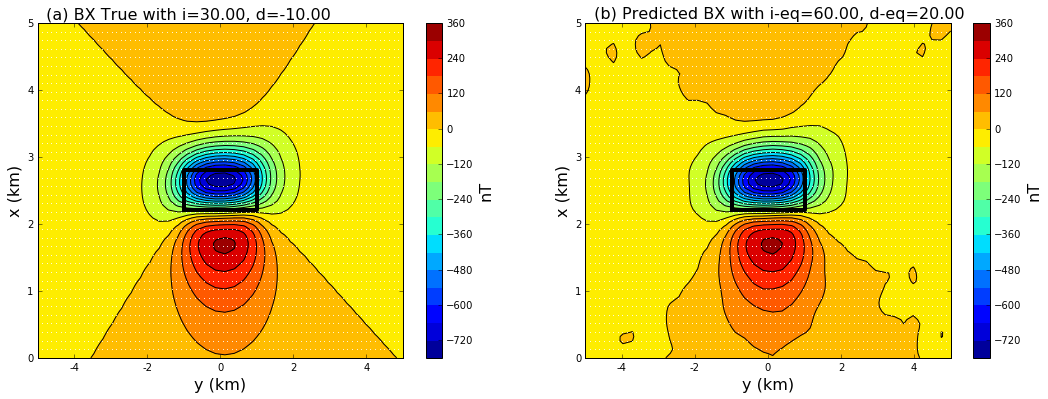

In [46]:
plt.figure(figsize=(18, 6))

af_L.Plot_Twomaps(xp, yp, BX_TRUE, BX_predicted, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) BX True with i=%4.2f, d=%4.2f" %(incs, decs), 
                figure_title2 = " (b) Predicted BX with i-eq=%4.2f, d-eq=%4.2f" %(inc_eq, dec_eq),
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

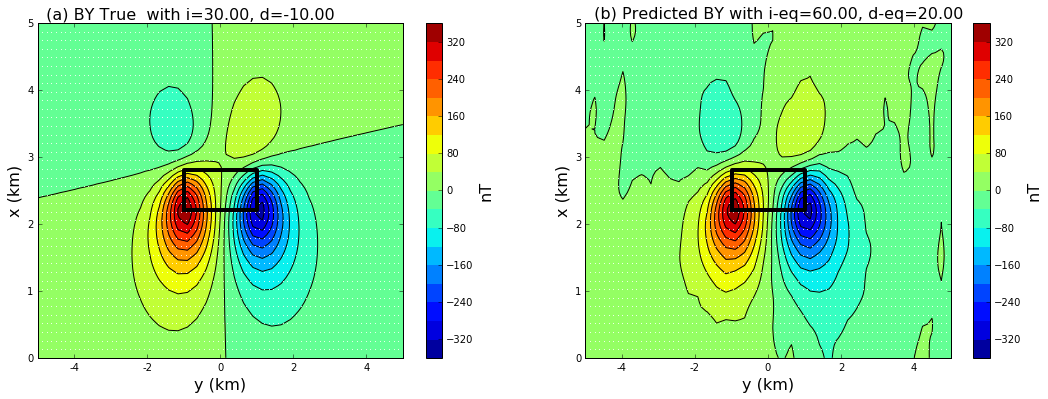

In [47]:
plt.figure(figsize=(18, 6))

af_L.Plot_Twomaps(xp, yp, BY_TRUE, BY_predicted, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) BY True  with i=%4.2f, d=%4.2f" %(incs, decs), 
                figure_title2 = " (b) Predicted BY with i-eq=%4.2f, d-eq=%4.2f" %(inc_eq, dec_eq),
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

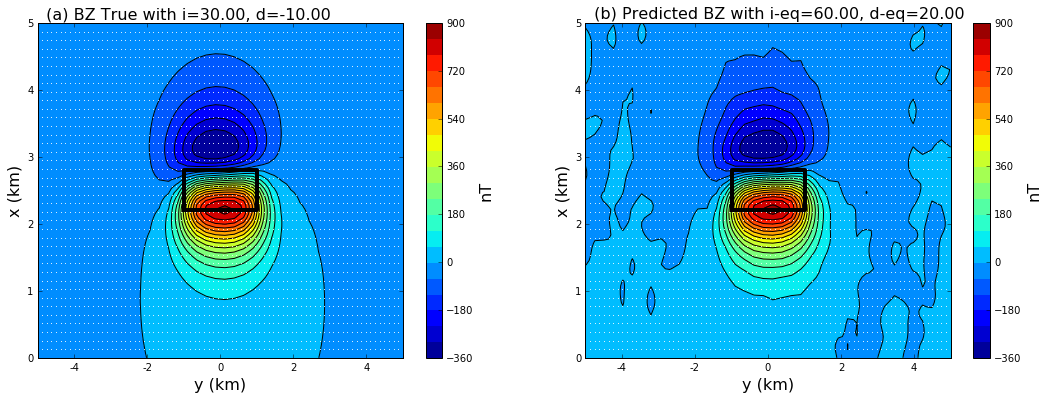

In [48]:
plt.figure(figsize=(18, 6))

af_L.Plot_Twomaps(xp, yp, BZ_TRUE, BZ_predicted, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) BZ True with i=%4.2f, d=%4.2f" %(incs, decs), 
                figure_title2 = " (b) Predicted BZ with i-eq=%4.2f, d-eq=%4.2f" %(inc_eq, dec_eq),
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

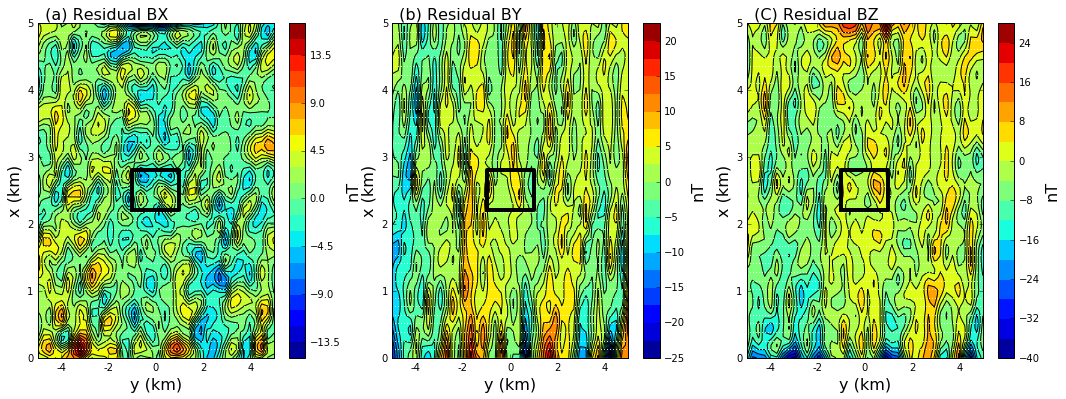

In [49]:
plt.figure(figsize=(18, 6))

af_L.Plot_Threemaps(xp, yp, Residual_BX, Residual_BY, Residual_BZ, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) Residual BX  ",
                figure_title2 = " (b) Residual BY",
                figure_title3 = " (C) Residual BZ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')


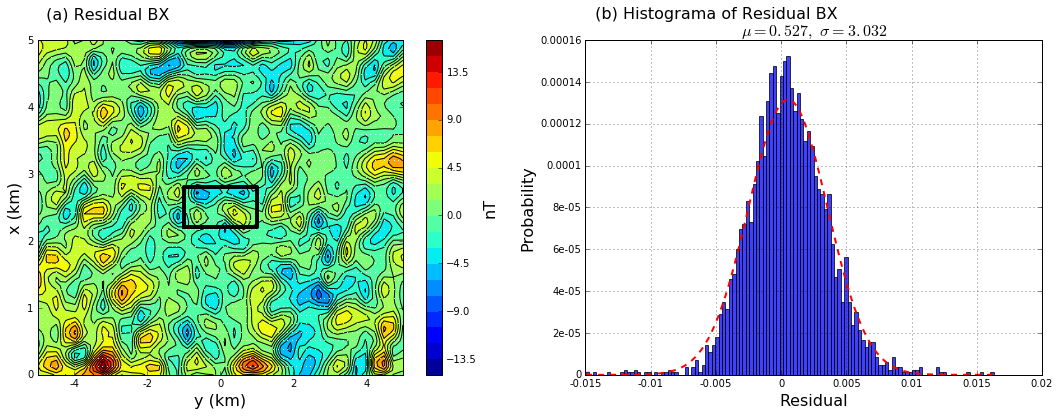

In [50]:
plt.figure(figsize=(18, 6))

af_L.Plot_Onemap_Histog(xp, yp, Residual_BX, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) Residual BX  ", figure_title2 = " (b) Histograma of Residual BX  ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

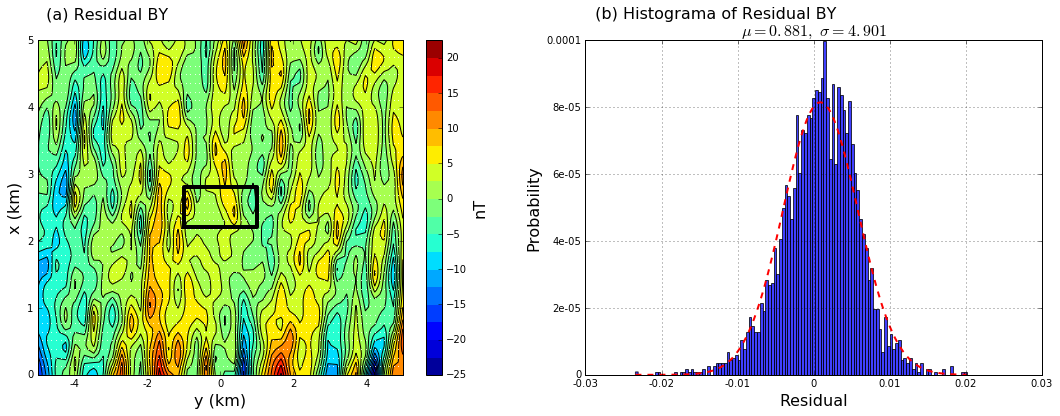

In [51]:
plt.figure(figsize=(18, 6))

af_L.Plot_Onemap_Histog(xp, yp, Residual_BY, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) Residual BY  ", figure_title2 = " (b) Histograma of Residual BY  ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

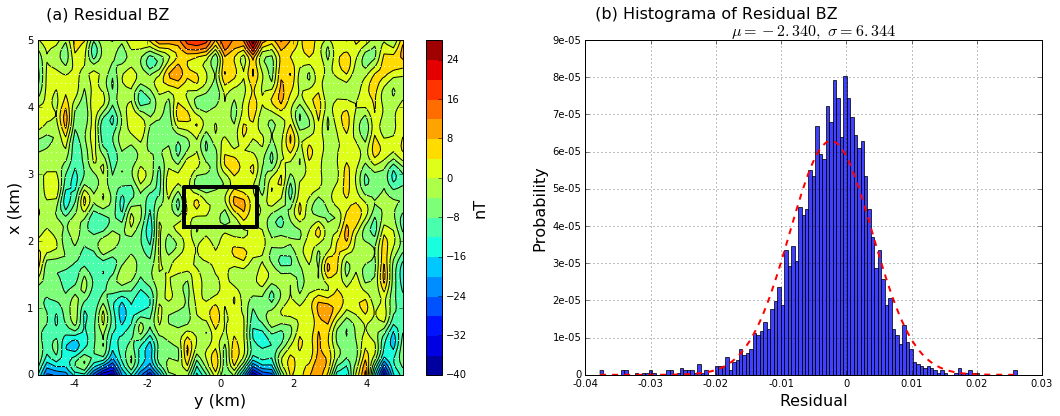

In [52]:
plt.figure(figsize=(18, 6))

af_L.Plot_Onemap_Histog(xp, yp, Residual_BZ, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) Residual BZ  ", figure_title2 = " (b) Histograma of Residual BZ  ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

### Computing TF via the projection of BX BY BZ oton the Geomagnetic field versor

In [53]:
print inc,dec
Fx, Fy, Fz =  dircos(inc, dec)

print Fx, Fy, Fz

TF_2 = np.dot(BX_TRUE,Fx) + np.dot(BY_TRUE,Fy) + np.dot(BZ_TRUE,Fz) 

20.0 10.0
0.925416578398 0.163175911167 0.342020143326


#### TF_2  IS COMPUTED VIA THE PROJECTION OF BX BY BZ (True) OTON THE GEOMAGNETIC FIELD 

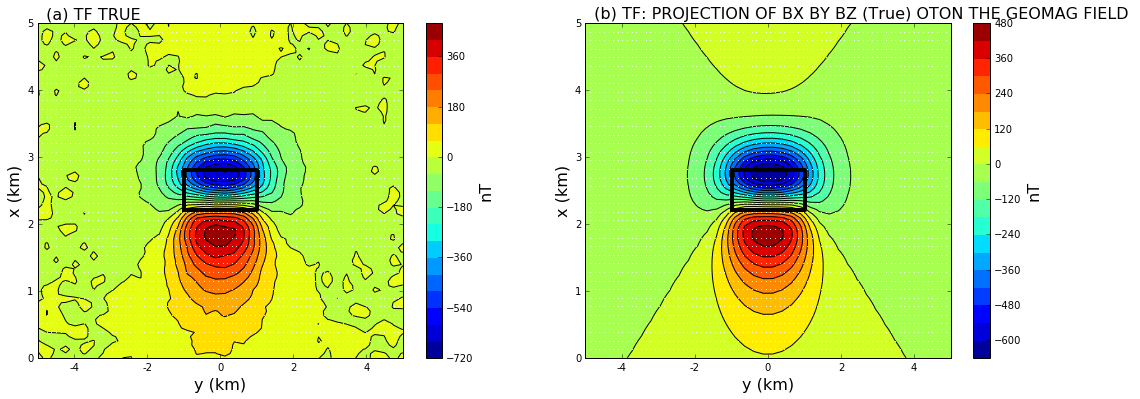

In [54]:
plt.figure(figsize=(18, 6))

af_L.Plot_Twomaps(xp, yp, tf, TF_2, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) TF TRUE  ",
                figure_title2 = " (b) TF: PROJECTION OF BX BY BZ (True) OTON THE GEOMAG FIELD ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')



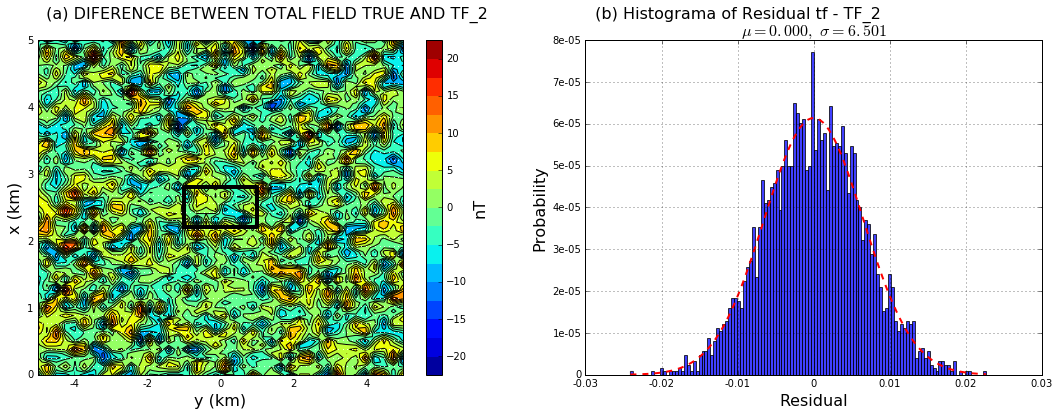

In [55]:
plt.figure(figsize=(18, 6))

af_L.Plot_Onemap_Histog(xp, yp, tf - TF_2, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) DIFERENCE BETWEEN TOTAL FIELD TRUE AND TF_2", figure_title2 = " (b) Histograma of Residual tf - TF_2 ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

#### TF_3 IS COMPUTED VIA THE PROJECTION OF THE PREDICTED BX BY BZ (VIA THE EQ LAYER) OTON THE GEOMAGNETIC FIELD

In [56]:
TF_3 = np.dot(BX_predicted,Fx) + np.dot(BY_predicted,Fy) + np.dot(BZ_predicted,Fz) 

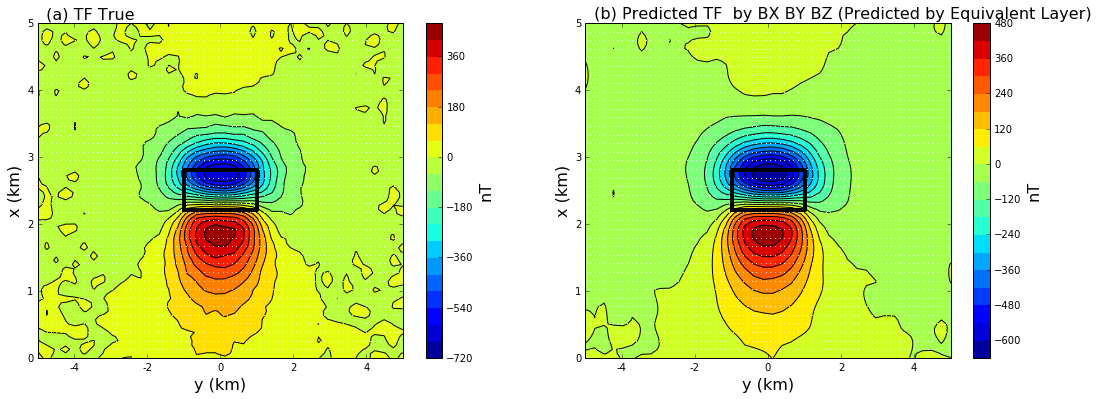

In [57]:
plt.figure(figsize=(18, 6))

af_L.Plot_Twomaps(xp, yp, tf, TF_3, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) TF True  ",
                figure_title2 = " (b) Predicted TF  by BX BY BZ (Predicted by Equivalent Layer)",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

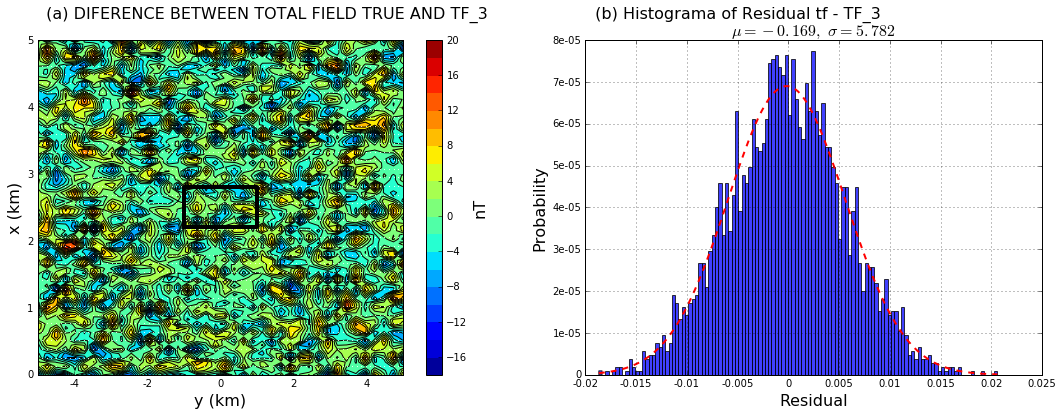

In [58]:
plt.figure(figsize=(18, 6))

af_L.Plot_Onemap_Histog(xp, yp, tf - TF_3, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) DIFERENCE BETWEEN TOTAL FIELD TRUE AND TF_3", figure_title2 = " (b) Histograma of Residual tf - TF_3 ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')

In [59]:
#   Calculei abaixo de outro modo a componente BX_predicted by Eq Layer

In [60]:
# equivalent layer
layer_transform = PointGrid(regular_single_grid['area'], z0, regular_single_grid['shape'])
layer_transform.addprop('magnetization', ang2vec(p, inc_eq, dec_eq))

# predicted bx by e bz
BX_predicted2 = sphere.bx(xp, yp, zp, layer_transform, pmag = None)

In [61]:
print inc_eq, dec_eq

60.0 20.0


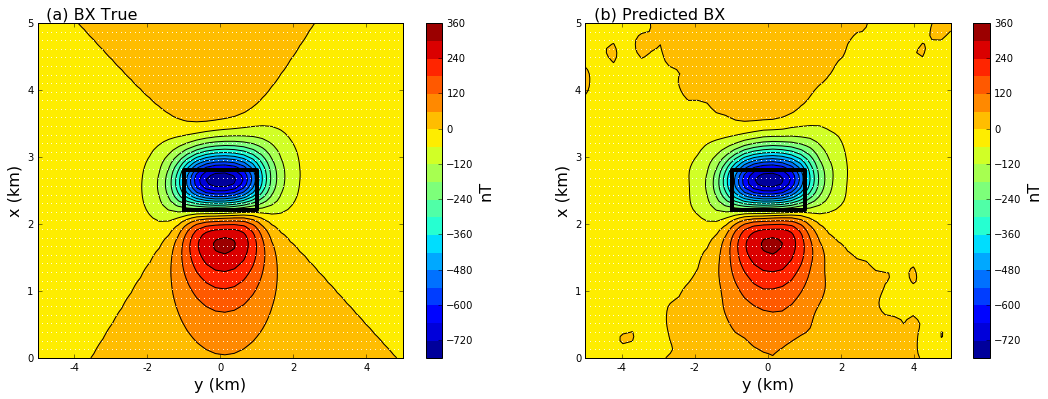

In [62]:
plt.figure(figsize=(18, 6))

af_L.Plot_Twomaps(xp, yp, BX_TRUE, BX_predicted2, regular_single_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model_single['projection'], 
                figure_title1 = " (a) BX True  ",
                figure_title2 = " (b) Predicted BX",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'nT')